In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import os
import datetime as dt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

   * [Data Loading](#data_load)
   * [Feature Importance](#feat_import)  
   * [Logistic Regression](#Log) 
   * [Random Forest](#random_forest) 
   * [Gradient Boosting](#gradient) 


## Data loading <a class="anchor" id="data_load"></a>

Importing file from where we left off after EDA.

In [2]:
df3 = pd.read_csv('../notebooks/df3.csv')

In [4]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     14482 non-null  object 
 1   region                      14482 non-null  object 
 2   year                        14482 non-null  int64  
 3   startmonth                  14482 non-null  float64
 4   participants_int            14465 non-null  float64
 5   new_participants_category   14465 non-null  object 
 6   labor_wage_dispute          14482 non-null  bool   
 7   land_farm_issue             14482 non-null  bool   
 8   police_brutality            14482 non-null  bool   
 9   political_behavior          14482 non-null  bool   
 10  price_increases_tax_policy  14482 non-null  bool   
 11  removal_of_politician       14482 non-null  bool   
 12  social_restrictions         14482 non-null  bool   
 13  protesterdemand1_y          144

In [5]:
df_target = df3[['Violent_Response']]

In [6]:
#dropping "duplicate" columns that are represented elsewhere in the df, as well as any target data and "future" data
df3.drop(columns=['participants_int','protesterdemand1_y','protesterdemand2_y','protesterdemand3_y','protesterdemand4_y','stateresponse1_y','stateresponse2_y','stateresponse3_y','stateresponse4_y','stateresponse5_y','stateresponse6_y','stateresponse7_y', 'start_date','end_date','Violent_Response','accomodation','arrests','beatings','crowd_dispersal','ignore','killings','shootings','first_response','last_response', 'responses_count','protesterviolence','dur_column','dur_column2' ] , inplace=True)

In [7]:
#Creating new df with dummy columns
df_encoded = pd.get_dummies(df3, columns=None)

In [17]:
#df_encoded.to_csv('df_encoded.csv', index=False)

## Feature Importance (from Prep file)<a class="anchor" id="feat_import"></a>

In [8]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [9]:
X = pd.DataFrame(df_encoded, columns=df_encoded.columns)
y = np.ravel(df_target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [10]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [11]:
list_of_tuples = list(zip(df_encoded.columns, rf.feature_importances_)) 

In [12]:
df_rf = pd.DataFrame(list_of_tuples, columns = ['feature', 'importance']) 

In [13]:
sorted_feat20 = df_rf.nlargest(20,'importance')

In [14]:
sorted_feat20.head()

,feature,importance
0,year,0.198388
1,startmonth,0.133842
185,new_participants_category_100-999,0.038529
179,region_Europe,0.033264
5,political_behavior,0.026687


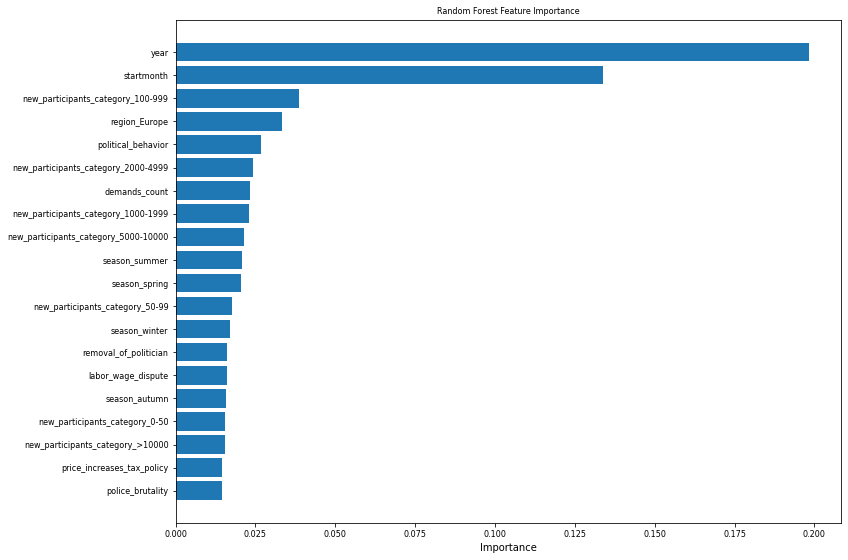

In [15]:
plt.barh('feature','importance',data=sorted_feat20)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
#plt.savefig('15_Feature_Importance.png')

In [16]:
sorted_feat50 = df_rf.nlargest(50,'importance')

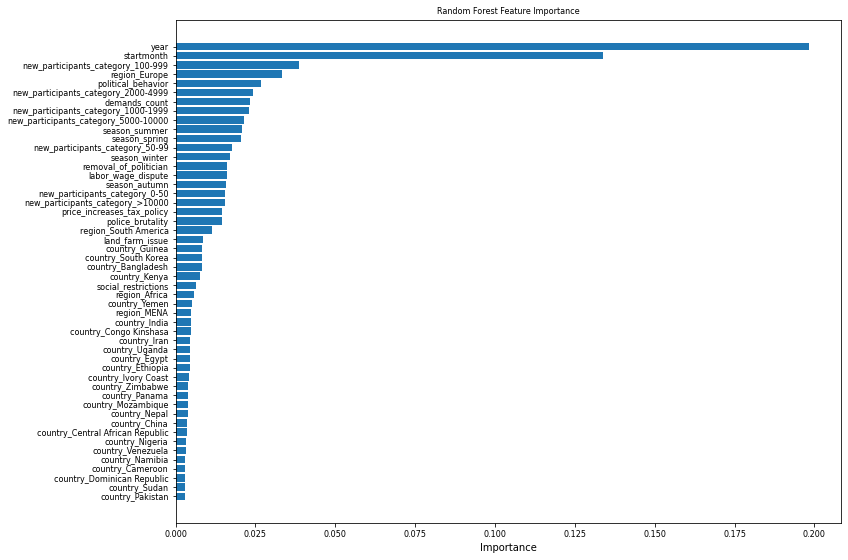

In [17]:
plt.barh('feature','importance',data=sorted_feat50)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
#plt.savefig('15b_Feature_Importance.png')

## Logistic Regression <a class="anchor" id="Log"></a>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

#Setting up x and y
X = df_encoded
features_list = df_encoded.columns
y = np.ravel(df_target)

In [19]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [20]:
# Setting up hyperparameter grid
c_space = [0.0001, 0.001, .01, .1, .5, 1, 10]
param_grid = {'C': c_space}

In [21]:
# Creating default model : logistic regression
logreg = LogisticRegression()

In [22]:
#Creating grid Search with log reg and cv=5
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

In [23]:
# Fitting to training data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Best Model Parameters: {}".format(logreg_cv.best_params_)) 
print("Best AUC-ROC score is {}".format(logreg_cv.best_score_))

Best Model Parameters: {'C': 0.5}
Best AUC-ROC score is 0.7478675828490925


## Random Forest <a class="anchor" id="random_forest"></a>

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Setting up x and y
X = df_encoded
features_list = df_encoded.columns
y = np.ravel(df_target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Setting up hyperparameter grid
n_estimators = np.arange(50, 400, 50)#number of trees in Forest
max_depth = np.arange(1,8)#depth of trees
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

# Creating default model : random forest 
rf = RandomForestClassifier()
# Creating grid Search with log reg and cv=5
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')

# Fitting the model
rf_cv.fit(X_train, y_train)

print("Best Random Forest Parameters: {}".format(rf_cv.best_params_)) 
print("Best score is {}".format(rf_cv.best_score_))

Best Random Forest Parameters: {'max_depth': 7, 'n_estimators': 250}
Best score is 0.7680480507684176


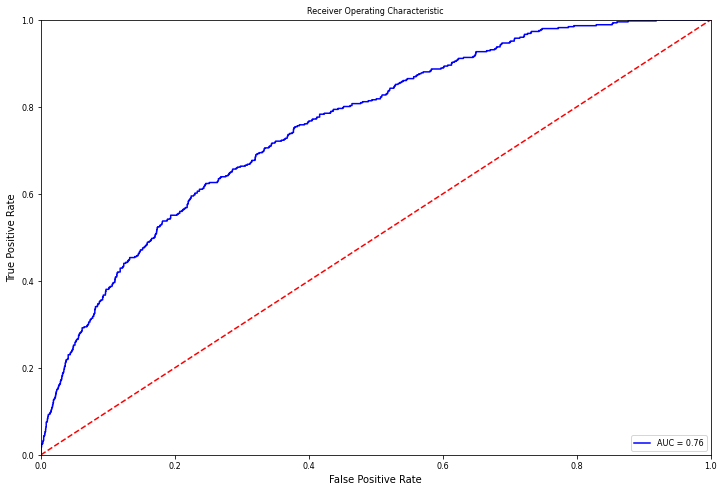

In [25]:
import sklearn.metrics as metrics
# calculate the false positive rate and true positive rate for all thresholds of the classification
probs = rf_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plotting with matplotlib

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Gradient Boosting <a class="anchor" id="gradient"></a>

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

X = df_encoded
y = np.ravel(df_target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

n_estimators = np.arange(100,600,100)
max_depth = [1,2,4,8]
learning_rate = [.05,.1,.2,.5,1]

param_dist = {'n_estimators': n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate}

gbm = GradientBoostingClassifier()

#RandomSearchCV object: 
gbm_cv = RandomizedSearchCV(gbm, param_distributions = param_dist, cv=5, scoring='roc_auc', n_iter=30)

#Fitting the model
gbm_cv.fit(X_train, y_train)

print("Best Gradient Boosting Parameters: {}".format(gbm_cv.best_params_)) 
print("Best score is {}".format(gbm_cv.best_score_))

Best Gradient Boosting Parameters: {'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1}
Best score is 0.7894852402495617


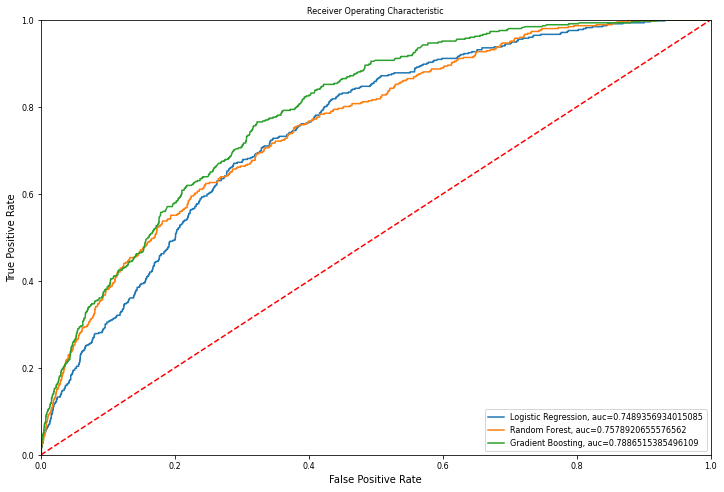

In [28]:
from sklearn import metrics

plt.figure(0).clf()
# calculate the false positive rate and true positive rate for all thresholds of the classification
#Log reg
probs = logreg_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(roc_auc))

#randomforest
probs = rf_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(roc_auc))

#GradientBoost
probs = gbm_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(roc_auc))



# plotting with matplotlib
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('AUC_updated.png')
plt.show()